In [129]:
import numpy as np
import pandas as pd
import sklearn.model_selection as ml
from scipy.stats import norm
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt


In [110]:
def to_row(arr):
    return arr.reshape(1, -1)

def to_col(arr):
    return arr.reshape(-1, 1)

def x_axis(arr):
    return arr[0, :]

def nb(nb_constr, points_training, points_test, labels_training, labels_test):
    naive_bayes = nb_constr(points_training, labels_training)
    print(f'Accuracy: {np.mean(naive_bayes.predict(points_test) == labels_test)}')
    plt.plot(*roc_curve(labels_test, [el[0] for el in naive_bayes.prob(points_test)])[0:1])
    plt.show()



In [2]:
spam_dataset = pd.read_csv("../datasets/spam.csv")
spam_labels = [val for val in spam_dataset['label'].values]
spam_points = spam_dataset.drop(['label'], axis=1).values

spam_points_training, spam_points_test, spam_labels_training, spam_labels_test = ml.train_test_split(spam_points, spam_labels, train_size=0.8)


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [3]:

class GNB:
    def __init__(self, data, labels):
        self.labels_variants = set(labels)
        self.mean = np.array([np.mean(data[labels == label], axis=0) for label in self.labels_variants])
        self.variance = np.array([np.var(data[labels == label], axis=0) for label in self.labels_variants])
        
    def _label_prob(self, label_index, point):
        pdf = norm(self.mean[label_index], self.variance[label_index]).pdf(point)
        return np.sum(np.log(pdf[~np.isnan(pdf)] + 0.0000001))
        
    def _prob_point(self, point):
        probabilities = np.ones(len(self.labels_variants))
        exp_sum = 0
        for (index, label) in enumerate(self.labels_variants):
            label_prob = self._label_prob(index, point)
            probabilities[index] = label_prob
            exp_sum += np.exp(probabilities[index])
        return np.exp(probabilities) / exp_sum
        
    def prob(self, points):
        return np.array([self._prob_point(point) for point in points])
        
    def predict(self, points):
        return np.argmax(self.prob(points), axis=1)


Accuracy: 0.8610206297502715


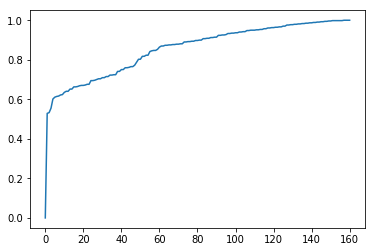

In [58]:
nb(GNB, spam_points_training, spam_points_test, spam_labels_training, spam_labels_test)


In [52]:
sms_spam_dataset = pd.read_csv("../datasets/smsspam.csv")
sms_spam_labels = (sms_spam_dataset["label"].values == 'spam').astype(int)
sms_spam_points = sms_spam_dataset.drop(['label'], axis=1).values.flatten()
sms_spam_points = (CountVectorizer().fit_transform(sms_spam_points) != 0).astype(int)

sms_spam_points_training, sms_spam_points_test, sms_spam_labels_training, sms_spam_labels_test = ml.train_test_split(sms_spam_points, sms_spam_labels, train_size=0.8)


In [61]:
class MNB:
    def __init__(self, data, labels):
        self.labels_variants = set(labels)
        self.bern_prob = np.array([np.asarray(np.mean(data[labels == label], axis=0))[0] for label in self.labels_variants])
        
    def _label_prob(self, label_index, point):
        point_prob = np.multiply(to_row(self.bern_prob[label_index]), point) + np.multiply((1 - to_row(self.bern_prob[label_index])), (1 - point))
        return np.sum(np.log(point_prob + 0.0000001))
        
    def _prob_point(self, point):
        probabilities = np.ones(len(self.labels_variants))
        exp_sum = 0
        for (index, label) in enumerate(self.labels_variants):
            label_prob = self._label_prob(index, point.toarray())
            probabilities[index] = label_prob
            exp_sum += np.exp(probabilities[index])
        return np.exp(probabilities) / exp_sum
        
    def prob(self, points):
        return np.array([self._prob_point(point) for point in points])
        
    def predict(self, points):
        return np.argmax(self.prob(points), axis=1)
    

Accuracy: 0.9901345291479821


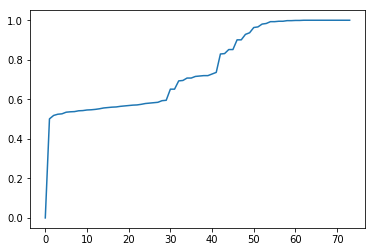

In [62]:
nb(MNB, sms_spam_points_training, sms_spam_points_test, sms_spam_labels_training, sms_spam_labels_test)



In [139]:

noisysine_dataset = pd.read_csv("../datasets/noisysine.csv")
noisysine_labels = [val for val in noisysine_dataset['y'].values]
noisysine_points = noisysine_dataset.drop(['y'], axis=1).values


In [232]:

def setup_polynomial(x, deg):
    return np.concatenate([np.power(x[:, 0], i) for i in range(deg + 1)]).reshape(-1, deg + 1, order='F')
  
def r2_score(x, y, weight):
    u = np.sum(np.square((x @ weight).flatten() - y))
    v = np.sum(np.square(np.mean(y) - y))
    return 1 - u / v

def regression(x, y):
    weight = np.linalg.inv(x.T @ x) @ (x.T @ y)
    return to_col(weight)

def pow_regression(points, poly_points, labels, show_plot=True):
    x_train, x_test, y_train, y_test = ml.train_test_split(poly_points, labels, train_size=0.8)
    
    weight = regression(x_train, y_train)
    
    print(f'R^2-score: {r2_score(x_test, y_test, weight)}')

    if show_plot:
        plt.scatter(points, labels)
        plt.plot(points, poly_points @ weight)
        plt.show()
    

R^2-score: 0.03358759597980454


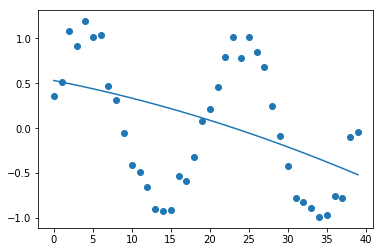

In [236]:
pow_regression(noisysine_points, setup_polynomial(noisysine_points, 2), noisysine_labels)


R^2-score: 0.19138218810463536


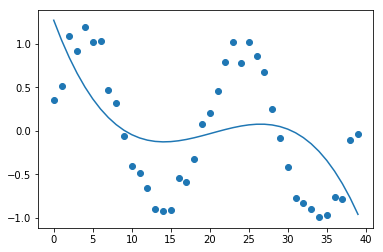

In [237]:
pow_regression(noisysine_points, setup_polynomial(noisysine_points, 3), noisysine_labels)


R^2-score: 0.2703918034386681


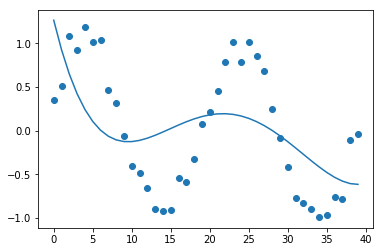

In [239]:
pow_regression(noisysine_points, setup_polynomial(noisysine_points, 4), noisysine_labels)


R^2-score: 0.9505093499136121


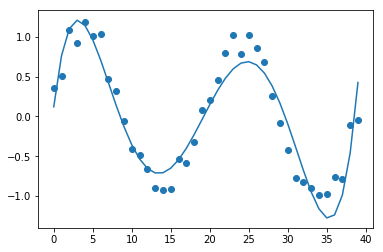

In [240]:
pow_regression(noisysine_points, setup_polynomial(noisysine_points, 5), noisysine_labels)



In [241]:
hydro_dataset = pd.read_csv("../datasets/hydrodynamics.csv")
hydro_labels = [val for val in hydro_dataset['y'].values]
hydro_points = hydro_dataset.drop(['y'], axis=1).values


In [256]:
def setup_square_hydro():
    new_points = np.concatenate((np.ones((hydro_points.shape[0], 1)), hydro_points), axis = 1)
    new_size = new_points.shape[1]
    return np.concatenate([new_points[:, i] * new_points[:, j] for i in range(new_size) for j in range(i, new_size)]).reshape(-1, 28, order='F')


In [261]:
pow_regression(hydro_points, setup_square_hydro(), hydro_labels, False)


R^2-score: 0.91551947078589
